In [4]:
%matplotlib inline
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import copy
import os

# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning

In [2]:
epochs = 30

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine-tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of same convolution.
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


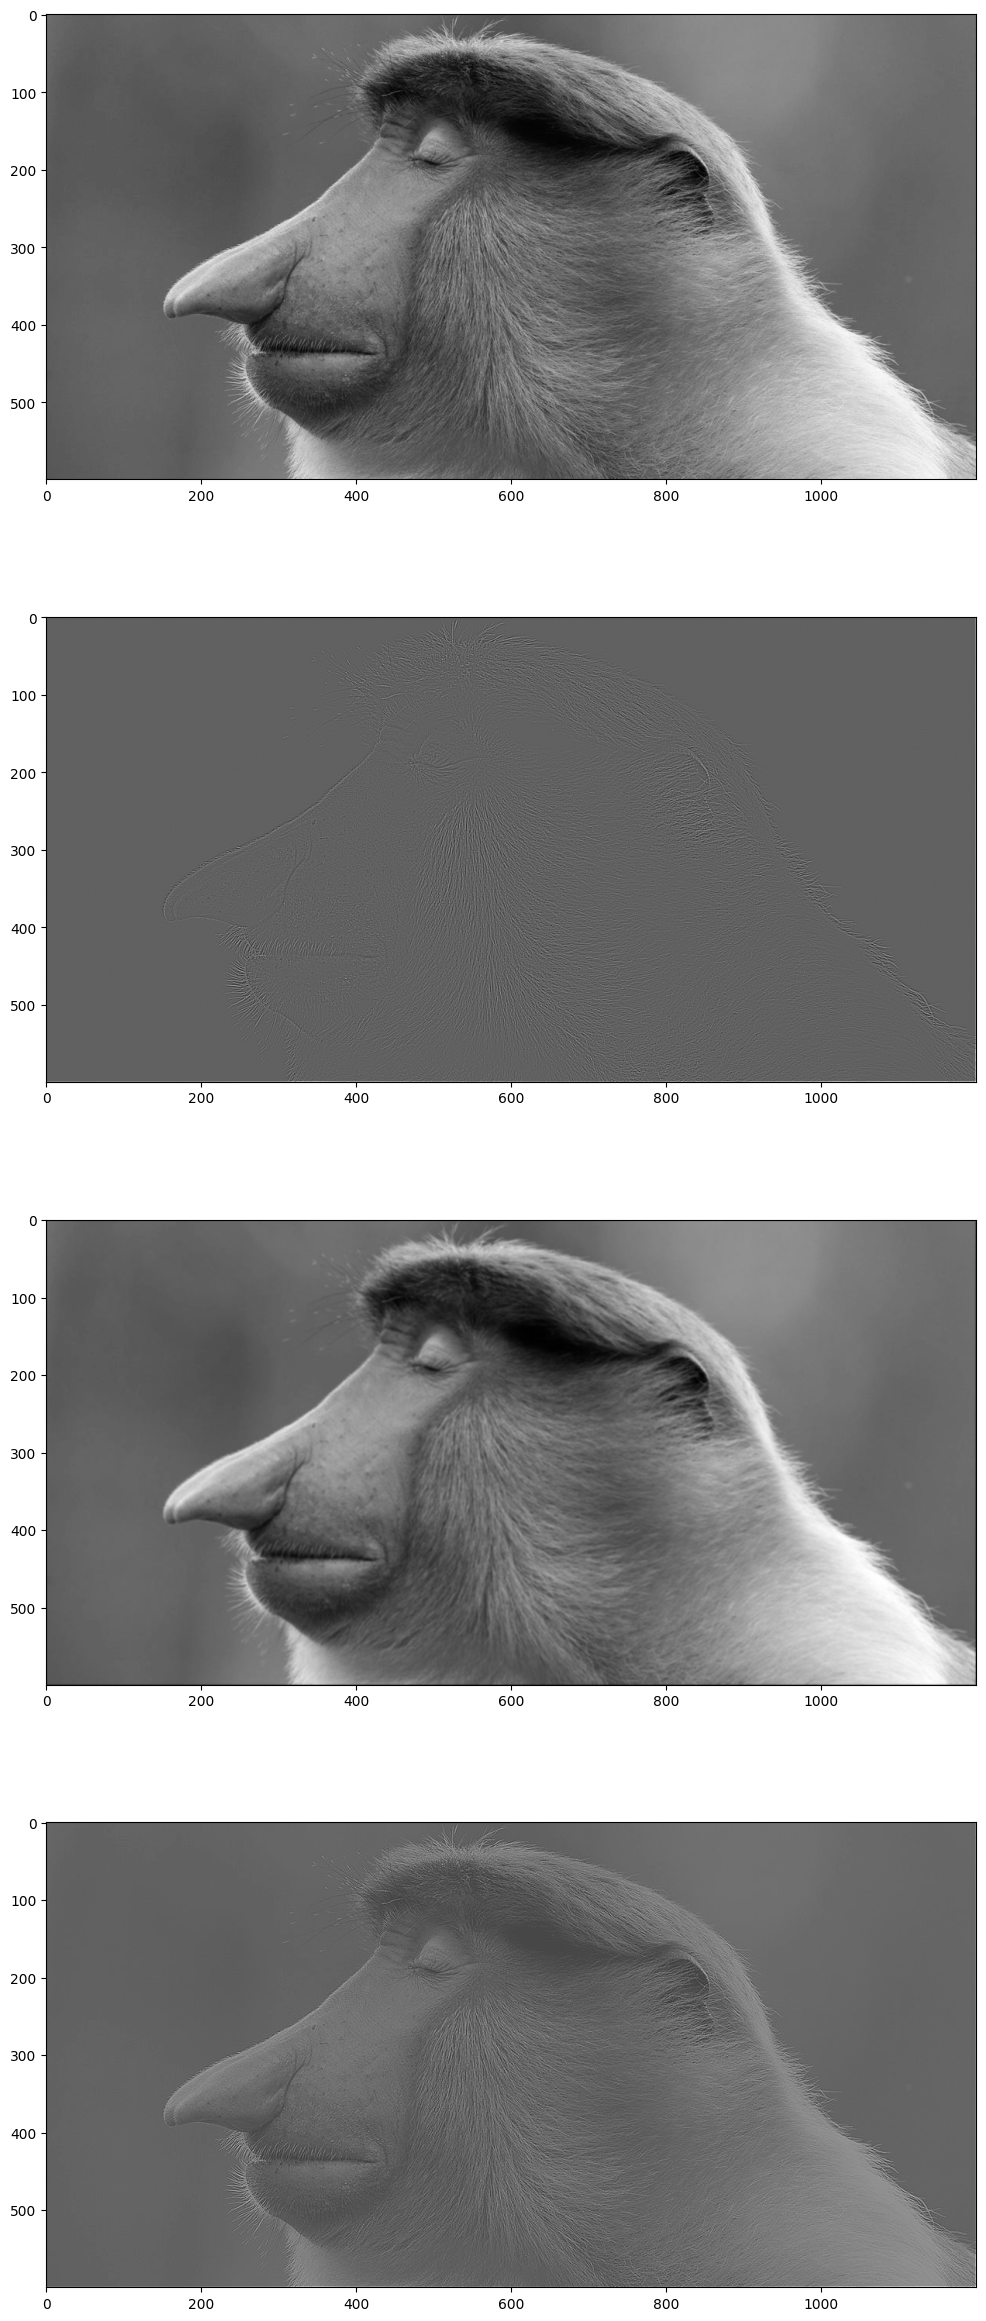

In [3]:
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

def calculate_padding(image, kernel, stride=1):
    return int(((image.shape[0] - 1)/stride - image.shape[0] + kernel.shape[0])/2)

# Implement same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)
def conv(image, kernel, stride=1):
    padding = calculate_padding(image, kernel, stride)
    padded_image = np.pad(image, padding)

    #Empty output
    output = np.zeros(image.shape)

    image_height = image.shape[0]
    image_width = image.shape[1]

    #Carry out convolution
    for row in range(0, image_height, stride):
        for col in range(0, image_width, stride):
            input_section = padded_image[row:row+kernel.shape[0], col:col+kernel.shape[0]]
            output[row][col] = np.sum(np.multiply(kernel, input_section))

    return output

# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

f, axarr = plt.subplots(4,1)

# How to load images using opencv
image_path = "monkey.jpeg" # add your file path here
#image_path = "pixelized.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scale so we dont have to deal with more than 1 channel

# Define your 3 kernels
kernel_1 = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])    # Edge detection
kernel_2 = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])
kernel_2 = np.multiply(kernel_2, 1/256)                     # Guassian blur
kernel_3 = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])        # Sharpen

# Perform the convolution (might take a couple of seconds depending on the implementation)
output1 = conv(image, kernel_1)
output2 = conv(image, kernel_2)
output3 = conv(image, kernel_3)

# plot the loaded image and the 3 convoluted images
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(output1, cmap="gray")
axarr[2].imshow(output2, cmap="gray")
axarr[3].imshow(output3, cmap="gray")

plt.show()

# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset we will use for this exercise can be downloaded on canvas**. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

In [5]:
################################
## Dataset and misc functions ##
################################
def load_datasets(image_size, batch_size, shuffle, augmentation=False):
    """
    returns: (train_loader, validation_loader, test_loader, conf_loader)
    """
    train_path = "101_ObjectCategories_2classes/train"
    test_path = "101_ObjectCategories_2classes/test"

    transformation_standard = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transformation_aug = transforms.Compose([
        #transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_data = datasets.ImageFolder(root=test_path, transform=transformation_standard)
    train_data = None
    if augmentation:
        train_data = datasets.ImageFolder(root=train_path, transform=transformation_aug)
    else:
        train_data = datasets.ImageFolder(root=train_path, transform=transformation_standard)

    val_data, train_data = random_split(train_data, [14, 45])
        
    return (
        DataLoader(train_data, batch_size=batch_size, shuffle=shuffle),
        DataLoader(val_data, batch_size=batch_size, shuffle=shuffle),
        DataLoader(test_data, batch_size=batch_size, shuffle=shuffle),
        DataLoader(test_data, batch_size=1, shuffle=False)
    )

In [6]:
##Some functions

def get_accuracy(network, loader):
    match = 0
    total = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            #preds_raw = network(data)
            #pred = list(prediction.argmax() for prediction in preds_raw)

            #match += np.equal(pred, labels).sum().item()
            #total += len(labels)

            preds = network(data)
            match += sum([np.argmax(preds[i]) == labels[i] for i in range(len(preds))])
            total += len(labels)
    return match/total

def get_prediction_labels(network, loader):
    preds_total = []
    targets_total = []
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            preds = network(images)
            pred = list(prediction.argmax() for prediction in preds)

            preds_total.append(pred)
            targets_total.append(labels)
    
    return targets_total, preds_total

In [7]:
#Network block
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        # Implement the forward function in the network
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.soft(x)

        return x

In [8]:
#Training block

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_model = copy.deepcopy(model)
    best_model_acc = 0

    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []

    for epoch in range(num_epochs):

        # Training
        #################
        model.train(True)
        for i, (data, labels) in enumerate(train_loader):
            preds = model(data) #.forward

            loss = criterion(preds ,labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            print(f'\rEpoch {epoch+1}, batch {i+1}/{len(train_loader)}, loss={loss}', end='')

        train_loss.append(loss)
        train_acc.append(get_accuracy(model, train_loader))

        # Validation
        ###################
        model.eval()
        #for batch_nr,(data, labels) in enumerate(val_loader):
        #    preds = model(data)
        #    loss = criterion(preds, labels)

        #valid_loss.append(loss)
        valid_acc.append(get_accuracy(model, validation_loader))

        if valid_acc[-1] > best_model_acc:
            print(f"\t > Found a better model, {best_model_acc} -> {valid_acc[-1]}")
            best_model = copy.deepcopy(model)
            best_model_acc = valid_acc[-1]

    #print(f'''\nFinished training!
    #    > Train acc {train_acc[-1]}
    #    > Valid acc {valid_acc[-1]}''')

    print(f"\nBest model accuracy: {best_model_acc}")
    return best_model, train_acc, valid_acc

def test_model(model, loader):
    temp = get_accuracy(model, loader)
    print('\nFinal results: ' + str(temp))
    return temp

In [12]:
# Hyperparams. Set these to reasonable values
EPOCHS = 25
BATCH_SIZE = 8
SHUFFLE = False #Set later in function call?
LEARNING_RATE = 1e-5
num_classes = 2

## Task 2: Training

Epoch 1, batch 6/6, loss=0.6925783157348633Found a better model, 0 -> 0.0714285746216774
Epoch 2, batch 6/6, loss=0.6902579069137573Found a better model, 0.0714285746216774 -> 0.1428571492433548
Epoch 4, batch 6/6, loss=0.6838130950927734Found a better model, 0.1428571492433548 -> 0.2142857164144516
Epoch 5, batch 6/6, loss=0.6795334815979004Found a better model, 0.2142857164144516 -> 0.2857142984867096
Epoch 23, batch 6/6, loss=0.62632817029953Found a better model, 0.2857142984867096 -> 0.3571428656578064
Epoch 26, batch 6/6, loss=0.6214448809623718Found a better model, 0.3571428656578064 -> 0.4285714328289032
Epoch 27, batch 6/6, loss=0.6184360980987549Found a better model, 0.4285714328289032 -> 0.5
Epoch 28, batch 6/6, loss=0.6136634945869446Found a better model, 0.5 -> 0.5714285969734192
Epoch 30, batch 6/6, loss=0.6035451292991638Found a better model, 0.5714285969734192 -> 0.6428571343421936
Epoch 36, batch 6/6, loss=0.5755785703659058Found a better model, 0.6428571343421936 -> 0.

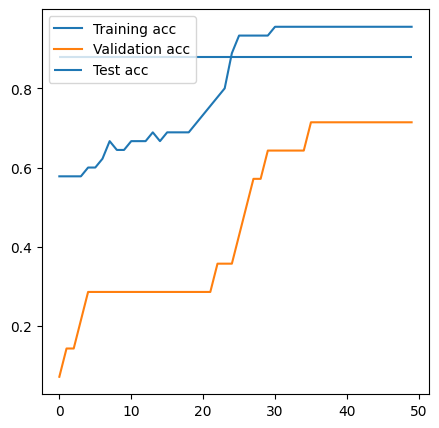

In [60]:
# Hyperparams. Set these to reasonable values
EPOCHS = 50
BATCH_SIZE = 8
SHUFFLE = False #Set later in function call?
LEARNING_RATE = 1e-5

# Load dataset
train_loader, validation_loader, test_loader, conf_loader = load_datasets(64, BATCH_SIZE, SHUFFLE, False)

# Load our network
model = Net()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5) # Added L2 regularization

# Train the model
trained_model, trainacc, valacc = train_model(model, criterion, optimizer, train_loader, validation_loader, EPOCHS)

# Test the model
final_accuracy = test_model(trained_model, test_loader)

#Confusion

targets, preds = get_prediction_labels(model, conf_loader)
c_matrix = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % c_matrix)


plt.figure(figsize=(5,5))
plt.plot(trainacc, label='Training acc')
plt.plot(valacc, label='Validation acc')
plt.hlines(final_accuracy, 0, len(valacc)-1, label="Test acc")
plt.legend()
plt.show

Epoch 1, batch 6/6, loss=0.7078271508216858Found a better model, 0 -> 0.4285714328289032
Epoch 8, batch 6/6, loss=0.6868782043457031Found a better model, 0.4285714328289032 -> 0.5
Epoch 14, batch 6/6, loss=0.6709693074226379Found a better model, 0.5 -> 0.5714285969734192
Epoch 15, batch 6/6, loss=0.663108229637146Found a better model, 0.5714285969734192 -> 0.7142857313156128
Epoch 50, batch 6/6, loss=0.5532566905021667
Best model accuracy: 0.7142857313156128

Final results: tensor(0.6400)
Confusion matrix:
 [[7 6]
 [5 7]]


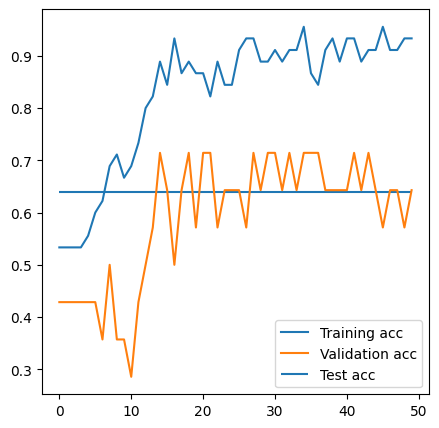

In [66]:
#########################
### WITH AUGMENTATION ###
#########################


# Hyperparams. Set these to reasonable values
EPOCHS = 50
BATCH_SIZE = 8
SHUFFLE = False #Set later in function call?
LEARNING_RATE = 1e-5


# Load the full dataset, perform the training/validation/test split and then load the subsets into dataloaders.
# Remember that the training images should be augmentated.
#DATA_DIR = "" # Path to dataset
#train_loader, validation_loader, test_loader, conf_loader = generate_dataloaders(create_dataset(True), BATCH_SIZE, SHUFFLE)

train_loader, validation_loader, test_loader, conf_loader = load_datasets(64, BATCH_SIZE, SHUFFLE, True)

# Load our network
model = Net()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5) # Added L2 regularization

# Train the model
trained_model, trainacc, valacc = train_model(model, criterion, optimizer, train_loader, validation_loader, EPOCHS)

# Test the model
final_accuracy = test_model(trained_model, test_loader)

#Confusion

targets, preds = get_prediction_labels(model, conf_loader)
c_matrix = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % c_matrix)


plt.figure(figsize=(5,5))
plt.plot(trainacc, label='Training acc')
plt.plot(valacc, label='Validation acc')
plt.hlines(final_accuracy, 0, len(valacc)-1, label="Test acc")
plt.legend()
plt.show

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should fine-tune Resnet18 to the small dataset which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

Epoch 1, batch 6/6, loss=0.4228047728538513Found a better model, 0 -> 0.5714285969734192
Epoch 3, batch 6/6, loss=0.21405072510242462Found a better model, 0.5714285969734192 -> 0.6428571343421936
Epoch 9, batch 6/6, loss=0.09235013276338577Found a better model, 0.6428571343421936 -> 0.7142857313156128
Epoch 25, batch 6/6, loss=0.01434575766324997
Best model accuracy: 0.7142857313156128

Final results: tensor(0.5600)
Confusion matrix:
 [[ 7  6]
 [ 2 10]]


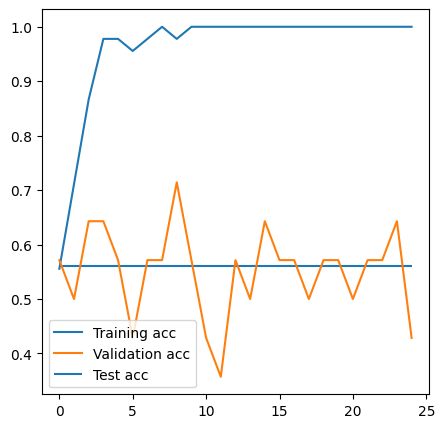

In [76]:
# Fine-tune a model to the dataset
# We use resnet18 as the model.
model_name = "resnet"

train_loader, validation_loader, test_loader, conf_loader = load_datasets(64, BATCH_SIZE, SHUFFLE, True)

# Do the things required for fine-tuning before training the model
model_ft = models.resnet18(pretrained=True)
num_fts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fts, num_classes)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr = LEARNING_RATE, weight_decay=1e-5) # L2 regularization

# Train the model
trained_model_ft, trainacc, valacc = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, validation_loader, EPOCHS)

# Test the model
final_accuracy = test_model(trained_model_ft, test_loader)

targets, preds = get_prediction_labels(model_ft, conf_loader)
c_matrix = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % c_matrix)

plt.figure(figsize=(5,5))
plt.plot(trainacc, label='Training acc')
plt.plot(valacc, label='Validation acc')
plt.hlines(final_accuracy, 0, len(valacc)-1, label="Test acc")
plt.legend()
plt.show

## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

Epoch 1, batch 6/6, loss=0.4725872874259949	 > Found a better model, 0 -> 0.5
Epoch 25, batch 6/6, loss=0.63545161485672
Best model accuracy: 0.5

Final results: tensor(0.6000)
Confusion matrix:
 [[7 6]
 [6 6]]


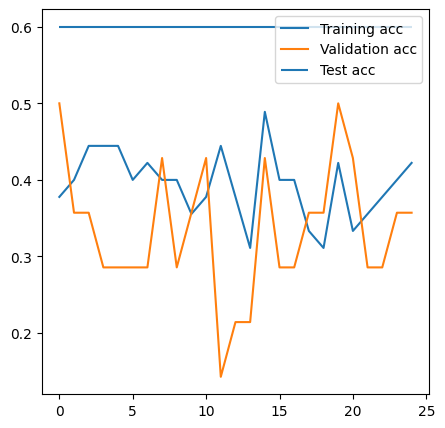

In [17]:
###########################
# Augmentation: ON
###########################

# Use a predefined model as a feature extractor
feature_extract = True

# We use resnet18 as the model.
model_fe = models.resnet18(pretrained=True)

train_loader, validation_loader, test_loader, conf_loader = load_datasets(64, BATCH_SIZE, SHUFFLE, True)

# Do the things required for fine-tuning before training the model
if feature_extract:
    for parameter in model_fe.parameters():
        parameter.requires_grad = False # allow fine-grained exclusion of subgraphs from gradient computation
num_fts = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_fts, num_classes)

criterion_fe = nn.CrossEntropyLoss()
optimizer_fe = torch.optim.Adam(Net().parameters(), lr = LEARNING_RATE, weight_decay=1e-5) # L2 regularization

# Train the model
trained_model_fe, trainacc, valacc = train_model(model_fe, criterion_fe, optimizer_fe, train_loader, validation_loader, EPOCHS)

# Test the model
final_accuracy = test_model(trained_model_fe, test_loader)

# Plots
targets, preds = get_prediction_labels(model_fe, conf_loader)
c_matrix = confusion_matrix(targets, preds)
print('Confusion matrix:\n %s' % c_matrix)

plt.figure(figsize=(5,5))
plt.plot(trainacc, label='Training acc')
plt.plot(valacc, label='Validation acc')
plt.hlines(final_accuracy, 0, len(valacc)-1, label="Test acc")
plt.legend()
plt.show